In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt

In [2]:
# Problem setup
n_assets = 4
q = 0.5  # Risk aversion parameter

mu = np.array([0.10, 0.20, 0.15, 0.12])  # Expected returns
Sigma = np.array([
    [0.005, -0.010, 0.004, -0.002],
    [-0.010, 0.040, -0.002, 0.004],
    [0.004, -0.002, 0.023, 0.002],
    [-0.002, 0.004, 0.002, 0.018]
])

In [3]:
dev = qml.device("default.qubit", wires=n_assets)

# Convert RY angles to weights (probability of measuring |1⟩)
def weights_from_thetas(thetas):
    return np.sin(thetas / 2) ** 2

@qml.qnode(dev)
def circuit(thetas):
    for i in range(n_assets):
        qml.RY(thetas[i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_assets)]

In [4]:
def cost_fn(thetas):
    weights = weights_from_thetas(thetas)
    expected_return = np.dot(mu, weights)
    risk = np.dot(weights, np.dot(Sigma, weights))
    penalty = 10 * (np.sum(weights) - 1.0) ** 2  # Encourage total weight = 1
    return -expected_return + q * risk + penalty

thetas = np.random.uniform(0, np.pi, n_assets, requires_grad=True)
opt = AdamOptimizer(0.1)
steps = 100
costs = []

for i in range(steps):
    thetas = opt.step(cost_fn, thetas)
    current_cost = cost_fn(thetas)
    costs.append(current_cost)
    if i % 10 == 0:
        print(f"Step {i} | Cost: {current_cost:.4f}")

Step 0 | Cost: 12.7782
Step 10 | Cost: -0.0284
Step 20 | Cost: 0.4755
Step 30 | Cost: -0.0370
Step 40 | Cost: -0.0944
Step 50 | Cost: -0.0846
Step 60 | Cost: -0.1174
Step 70 | Cost: -0.1221
Step 80 | Cost: -0.1214
Step 90 | Cost: -0.1219


In [5]:
weights = weights_from_thetas(thetas)
weights = weights / np.sum(weights)  # Normalize

print("Optimized Portfolio Allocation:")
for i, w in enumerate(weights):
    print(f"Asset {i+1}: {float(w)*100:.2f}%")

Optimized Portfolio Allocation:
Asset 1: 44.18%
Asset 2: 1.06%
Asset 3: 47.34%
Asset 4: 7.43%


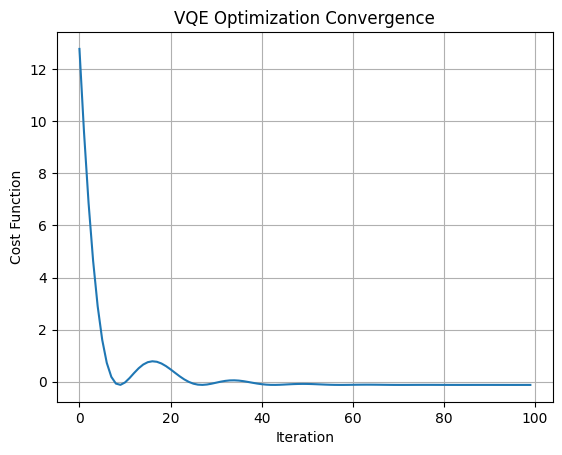

In [8]:
plt.plot(range(steps), costs)
plt.title("VQE Optimization Convergence")
plt.xlabel("Iteration")
plt.ylabel("Cost Function")
plt.grid(True)
plt.show()

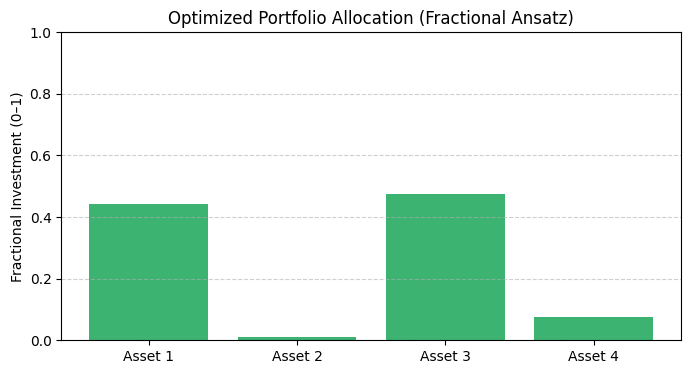

In [6]:
asset_labels = [f"Asset {i+1}" for i in range(n_assets)]

plt.figure(figsize=(8, 4))
plt.bar(asset_labels, weights, color='mediumseagreen')
plt.title("Optimized Portfolio Allocation (Fractional Ansatz)")
plt.ylabel("Fractional Investment (0–1)")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

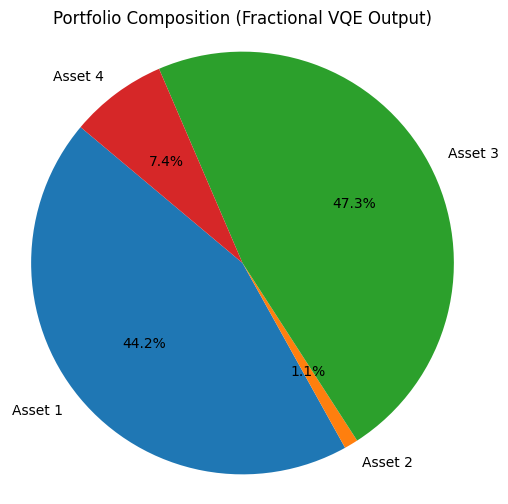

In [7]:
plt.figure(figsize=(6, 6))
plt.pie(weights, labels=asset_labels, autopct='%1.1f%%', startangle=140)
plt.title("Portfolio Composition (Fractional VQE Output)")
plt.axis('equal')
plt.show()